# Trabajo Práctico 3: Sensor

### Objetivos:

+ Tomar una foto con el celular tapando bien el sensor para que no entre nada de luz (se debe obtener una imagen negra, pero no todos los píxeles estarán en cero ya que hay ruido). 

+ Hacer un análisis estadístico del ruido indicando media, desvío y comentando las posibles fuentes del mismo.

## Ruido Blanco

Vamos a generar un poco de ruido y medirlo.

In [1]:
# Cargamos las bibliotecas necesarias

import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

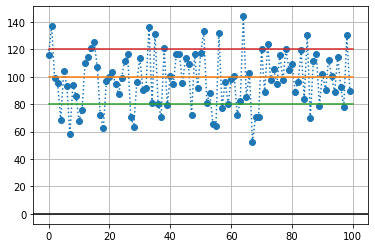

In [2]:
#Cantidad de muestras de la variable aleatoria voy a tomar
n_muestras = 500000

media = 100
std = 20

x = np.random.normal(media, std, n_muestras)

y = x

# Solo dibuja las primeras 100
n_show = np.min([n_muestras, 100])

plt.axhline(color='k')
plt.grid()

plt.plot(y[:n_show], 'o:')
plt.plot([0, n_show], [media, media])
plt.plot([0, n_show], [media-std, media-std])
plt.plot([0, n_show], [media+std, media+std])

Distribución "normal" (Campana de Gauss)

$$ f(x) = \frac{1}{\sqrt{2\pi}\sigma} e^{-\frac{1}{2}(\frac{x-\mu}{\sigma})^2} $$

Diferencia entre media y media estimada = -0.005403262000655218


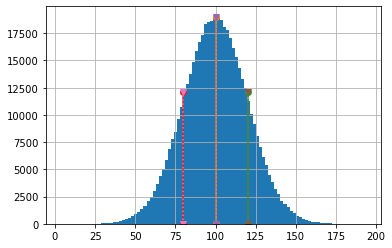

In [3]:
h, bins, patches = plt.hist(y, bins=100)

bin_max = np.argmax(h)
h_max = h[bin_max]

plt.grid()
plt.plot([media, media], [0, h_max], 'o-')
plt.plot([media+std, media+std], [0, h_max*.635], 'o-')
plt.plot([media-std, media-std], [0, h_max*.635], 'o-')

media_est = np.mean(y)
std_est = np.std(y)

plt.plot([media_est, media_est], [0, h_max], 'v:')
plt.plot([media_est+std_est, media_est+std_est], [0, h_max*.635], 'v:')
plt.plot([media_est-std_est, media_est-std_est], [0, h_max*.635], 'v:')

error_en_media_est = (media - media_est)
print('Diferencia entre media y media estimada =', error_en_media_est)

# En naranja se marca la media
# En rojo y verde se marcan los desvios estandar

# Análisis Global Estadístico


+ **Leemos lista de fotos que vamos a procesar**


In [4]:
# glob nos permite crear lista con nombres de archivo en un directorio
from glob import glob

img_fnames = glob('./fotos/*.jpg')
print(img_fnames)

['./fotos\\IMG_20210513_211613924.jpg', './fotos\\IMG_20210513_211616658.jpg', './fotos\\IMG_20210513_211619375.jpg', './fotos\\IMG_20210513_211622255.jpg', './fotos\\IMG_20210513_211625415.jpg', './fotos\\IMG_20210513_211628099.jpg']


Las fotos fueron sacadas con una camara de 12 megapixeles - f/1.8

+ **Mostramos una de las fotos, en este caso elegimos la primera**

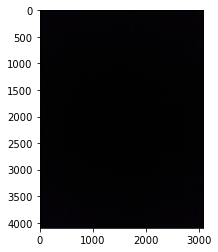

In [5]:
img = cv2.imread(img_fnames[0])

# Pasamos a RGB porque OpenCV usa BGR
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)

+ **Apaisamos la foto**

img.shape = (4096, 3072, 3)
La transponemos:
alto = 3072px, ancho = 4096px


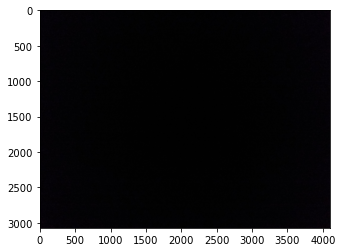

In [6]:
print("img.shape =", img_rgb.shape)
print("La transponemos:")
img_t = cv2.transpose(img_rgb)
alto = img_t.shape[0]
ancho = img_t.shape[1]
print("alto = {0}px, ancho = {1}px".format(alto, ancho))
plt.imshow(img_t)

+ **Vamos a repetir los pasos anteriores pero para todas las imagenes:**
  1. Leerlas
  2. Pasarlas a RGB
  3. Apaisarlas

In [7]:
imgs = []
for fname in img_fnames:
    img = cv2.imread(fname)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if img.shape[0] > img.shape[1]:
        img = cv2.transpose(img)
    imgs.append(img)

print("Se cargaron {0} imágenes".format(len(imgs)))

Se cargaron 6 imágenes


# Inspección

+ Comenzamos con el análisis de las imagenes, para ello utilizamos la primera de nuestra lista. De esta manera podemos observar y detallar lo que capturó el sensor.

In [8]:
img = imgs[0]

# Menor valor de intensidad que registró
print("Menor intensidad =", np.min([img]))

# Mayor valor de intensidad que registró
print("Mayor intensidad =", np.max([img]))

Menor intensidad = 0
Mayor intensidad = 62


+ **Normalizamos la imagen**

Mayor intensidad = 255


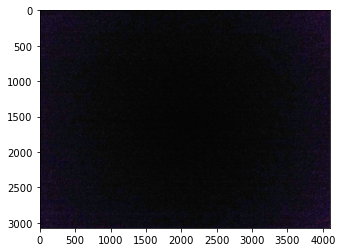

In [30]:
#El valor que esta en 62 lo ponemos en 255

img_norm = cv2.normalize(img, 0, 255, norm_type=cv2.NORM_INF)
#NORM_INF nos da la norma infinito de la matriz (el máximo de los valores absolutos de los elementos).

print("Mayor intensidad =", np.max([img_norm]))

plt.imshow(img_norm)

## Ruido en el campo del sensor

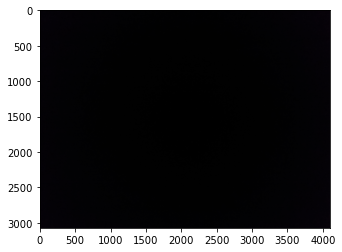

In [10]:
# Promediamos sobre varias fotos

img_promedio = np.zeros_like(imgs[0])
n = len(imgs)
for img in imgs:
    img_promedio = img_promedio + img/n

# convertimos de nuevo a char
img_promedio = img_promedio.astype(np.uint8)

plt.imshow(img_promedio)

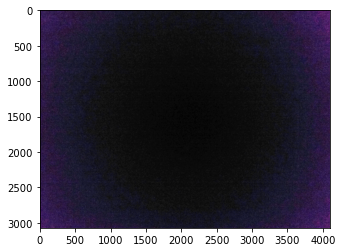

In [11]:
# Normalizamos
img_promedio_norm = cv2.normalize(img_promedio, 0, 255, norm_type=cv2.NORM_INF)
plt.imshow(img_promedio_norm)

## Ruido por color y por píxel

In [12]:
# Apilamos todas las imágenes:
imgs_np = np.stack(imgs)
#nuevo tensor que tiene dimension = (cant imagenes,fila,columna,color)

# Media:
img_media = np.mean(imgs_np, axis=0)

# desvío:
img_std = np.std(imgs_np, axis=0)

print(imgs_np.shape)
# para ver los resultados vamos a dibujar contornos:

(6, 3072, 4096, 3)


In [13]:
print(img_media.shape)
print(img_std.shape)

(3072, 4096, 3)
(3072, 4096, 3)


In [26]:
def dibujar_contorno(mat):
    fig = plt.figure()
    X, Y = np.meshgrid(range(ancho), range(alto))
    Z = mat

    # decimación
    dec = 16

    fig = plt.figure(figsize=(16,12))
    cp = plt.contourf(X[::dec], Y[::dec], Z[::dec])
    fig.colorbar(cp)
    plt.show()

+ Ahora mostramos los desvíos para los tres canales de color

Std Rojo


<Figure size 432x288 with 0 Axes>

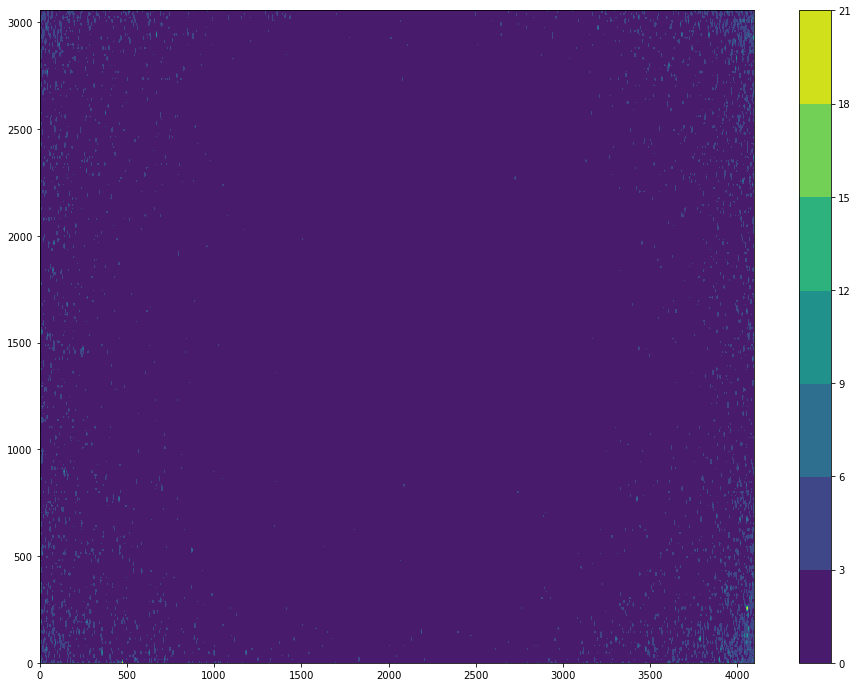

In [27]:
print('Std Rojo')
dibujar_contorno(img_std[:,:,0])

Std Verde


<Figure size 432x288 with 0 Axes>

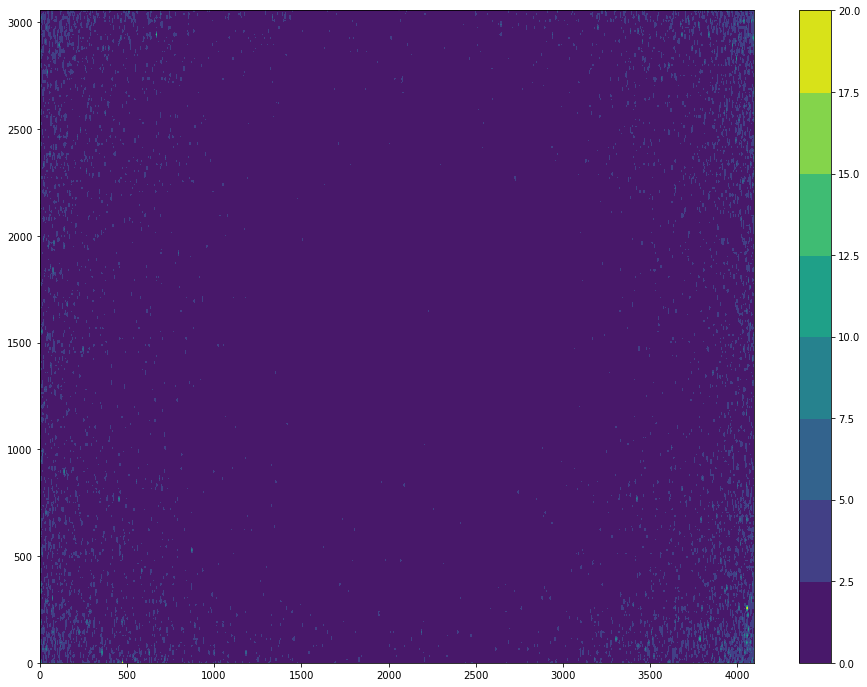

In [28]:
print('Std Verde')
dibujar_contorno(img_std[:,:,1])

Std Azul


<Figure size 432x288 with 0 Axes>

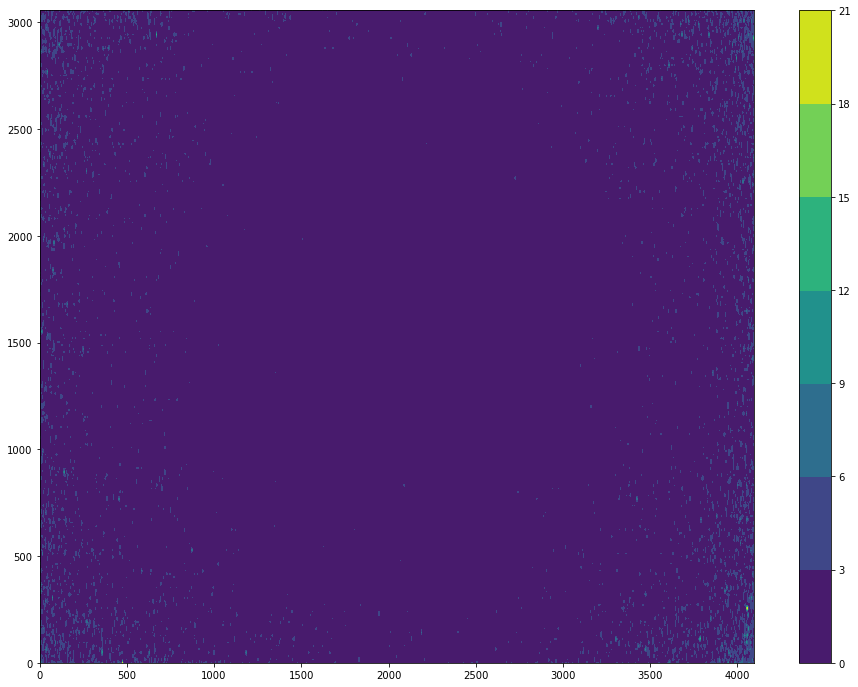

In [29]:
print('Std Azul')
dibujar_contorno(img_std[:,:,2])

+ Mostramos la media para los tres canales de color

Media Rojo


<Figure size 432x288 with 0 Axes>

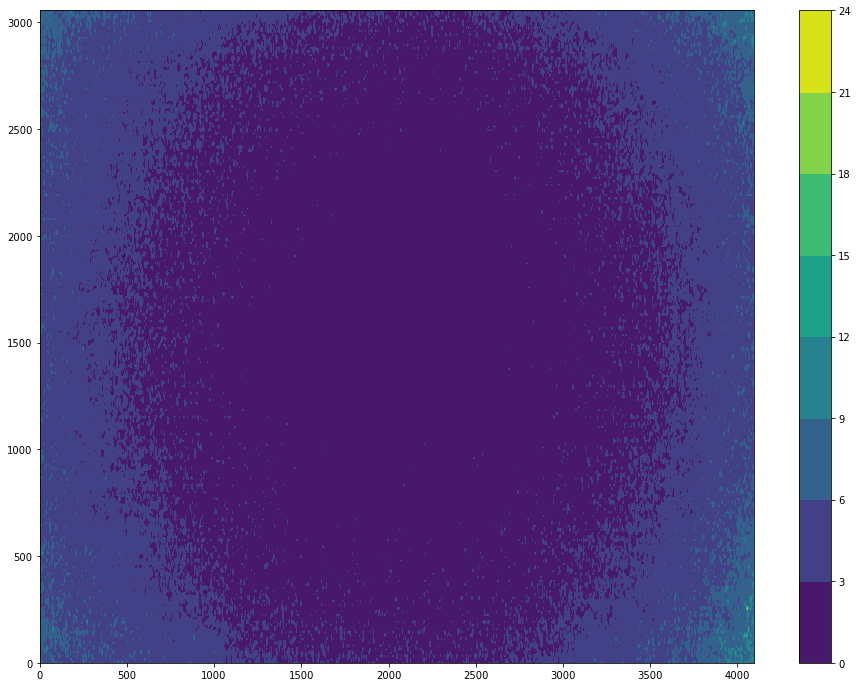

In [18]:
print('Media Rojo')
dibujar_contorno(img_media[:,:,0])

Media Verde


<Figure size 432x288 with 0 Axes>

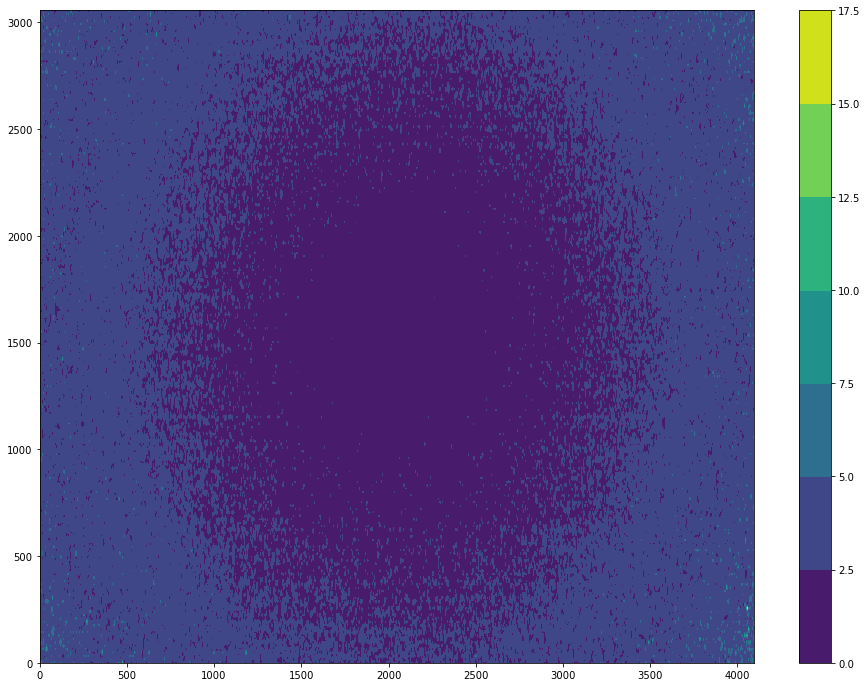

In [19]:
print('Media Verde')
dibujar_contorno(img_media[:,:,1])

Media Azul


<Figure size 432x288 with 0 Axes>

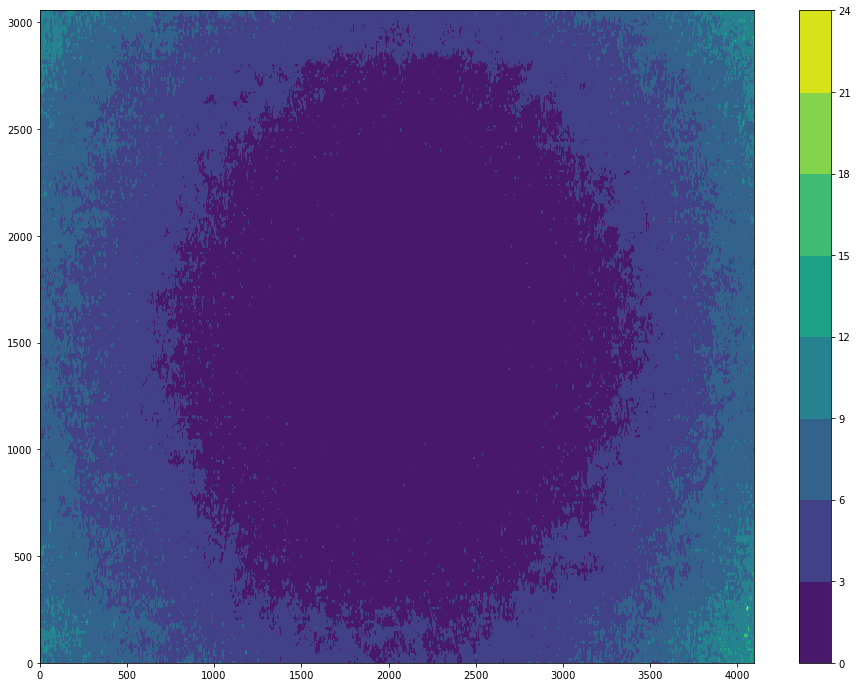

In [20]:
print('Media Azul')
dibujar_contorno(img_media[:,:,2])

## Estadísticas de ruido: relación entre media y desvío

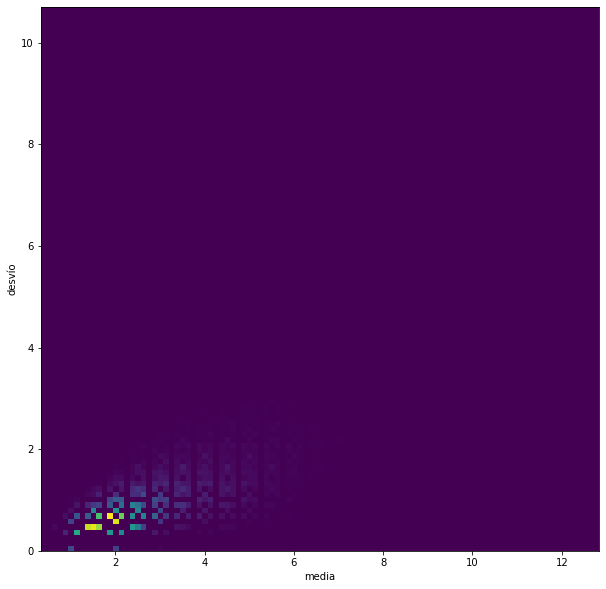

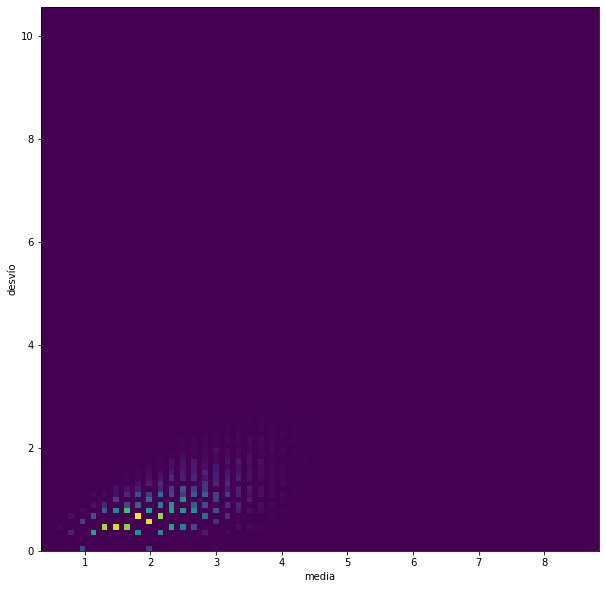

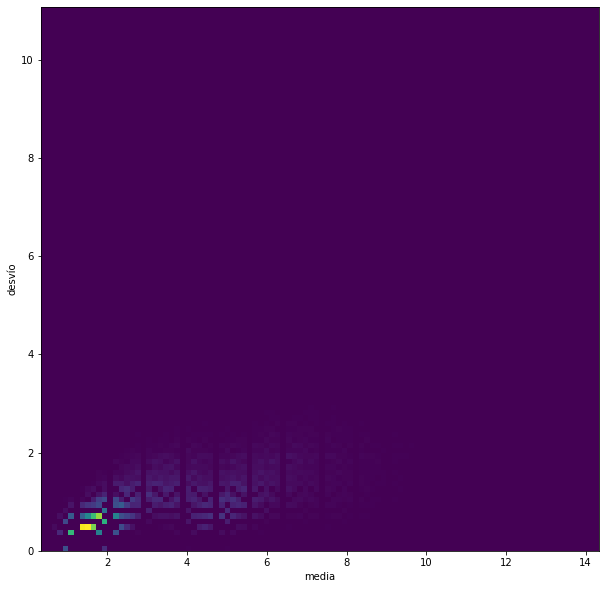

In [21]:
# Ahora vamos a ver estadísticas globales de ruido de todos los píxeles por color

dec = 100

todos_los_rojos_std = np.ravel(img_std[:,:,0])
todos_los_rojos_media = np.ravel(img_media[:,:,0])

todos_los_verdes_std = np.ravel(img_std[:,:,1])
todos_los_verdes_media = np.ravel(img_media[:,:,1])

todos_los_azules_std = np.ravel(img_std[:,:,2])
todos_los_azules_media = np.ravel(img_media[:,:,2])

#Aca uso histograma en 2 dimensiones, es lo mismo pero aca ponen x e y
plt.figure(figsize=(10,10))
plt.xlabel('media')
plt.ylabel('desvío')
cb = plt.hist2d(todos_los_rojos_media[::dec], todos_los_rojos_std[::dec], bins=100)
 # plt.colorbar(cb)

plt.figure(figsize=(10,10))
plt.xlabel('media')
plt.ylabel('desvío')
cb = plt.hist2d(todos_los_verdes_media[::dec], todos_los_verdes_std[::dec], bins=100)
 # plt.colorbar(cb)

plt.figure(figsize=(10,10))
plt.xlabel('media')
plt.ylabel('desvío')
cb = plt.hist2d(todos_los_azules_media[::dec], todos_los_azules_std[::dec], bins=100)
 # plt.colorbar(cb)

Aca tenemos diferentes valores de media y de desvio. Esto significa que probablemente cada pixel tiene su propia distribucion asociada, y no son iguales en todos los pixeles. 

# Histograma

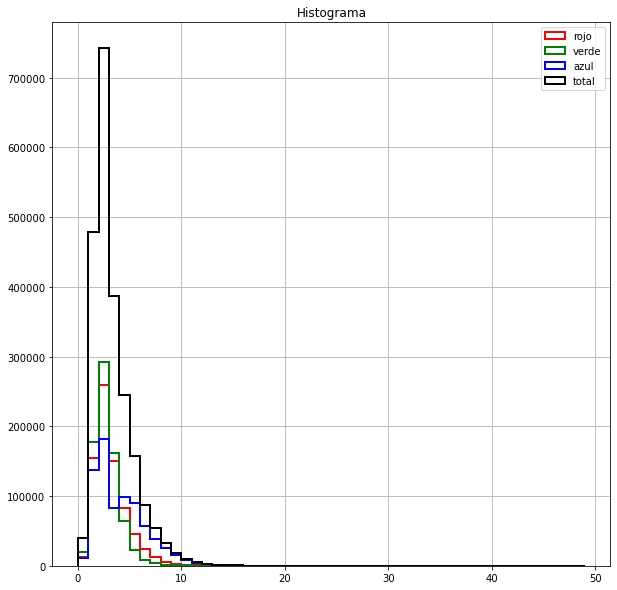

In [22]:
dec = 100
plt.figure(figsize=(10,10))
plt.title('Histograma')

todos_los_rojos = np.ravel(imgs_np[:,:,:,0])
todos_los_verdes = np.ravel(imgs_np[:,:,:,1])
todos_los_azules = np.ravel(imgs_np[:,:,:,2])

plt.grid()
i_max = 50
_ = plt.hist(todos_los_rojos[::dec], bins=range(i_max), color='red',histtype='step', linewidth=2.0)
_ = plt.hist(todos_los_verdes[::dec], bins=range(i_max), color='green', histtype='step', linewidth=2.0)
_ = plt.hist(todos_los_azules[::dec], bins=range(i_max), color='blue', histtype='step', linewidth=2.0)

_ = plt.hist(np.ravel(imgs_np)[::dec], bins=range(i_max), color='black', histtype='step', linewidth=2.0)
plt.legend(['rojo', 'verde', 'azul', 'total'])

# Analisis de Resultados y Conclusiones

*¿Qué es lo que observamos?*

Supuestamente debería verse todo negro puesto que no tendría que llegar luz al sensor. Este resultado puede ser consecuencia de un error al realizar el experimento, pues si bien se efectuó en una habitación a oscuras y tapando el sensor, puede entrar un poco de luz por los bordes de la lente. Asimismo puede ser consecuencia de los efectos térmicos del circuito que generen este ruido sobre el sensor.
